Bharath Gunasekaran

CMPE 258 

Assignment 5 Part A


### About the problem and dataset:

Use NYC's openly available taxi-fare dataset to predict the price of a Taxi ride. 

**Dataset**: 
100K records of NYC taxi trip including below signals:
 *   key                
 *   fare_amount        
 *   pickup_datetime    
 *   pickup_longitude   
 *   pickup_latitude    
 *   dropoff_longitude  
 *   dropoff_latitude   
 *   passenger_count              


# Mounting Google Drive to load data. Since the data was 80 MB I was not able to load copy the file over. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext tensorboard

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium

from folium import plugins

import tensorflow as tf
import tensorflow.keras as keras

device = "gpu"

if device == "tpu":
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
  strategy = tf.distribute.MultiWorkerMirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CommunicationImplementation.AUTO


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/CMPE-258/HW5/new-york-city-taxi-fare-prediction/train-sample.csv',nrows=15000)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                15000 non-null  object 
 1   fare_amount        15000 non-null  float64
 2   pickup_datetime    15000 non-null  object 
 3   pickup_longitude   15000 non-null  float64
 4   pickup_latitude    15000 non-null  float64
 5   dropoff_longitude  15000 non-null  float64
 6   dropoff_latitude   15000 non-null  float64
 7   passenger_count    15000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 937.6+ KB


In [ ]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(data)) < 0.85
traindf = data[msk]
evaldf = data[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)
traindf.head()

12745
2255


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
data

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
1048570,05:00.0,7.0,2014-09-13 17:05:00 UTC,-73.962580,40.778222,-73.973827,40.764247,4
1048571,48:25.0,8.9,2012-02-04 18:48:25 UTC,-73.990152,40.740837,-73.995193,40.760206,4
1048572,16:00.0,6.9,2012-06-22 19:16:00 UTC,-73.963888,40.767992,-73.974017,40.751570,1
1048573,12:00.0,12.0,2014-01-10 19:12:00 UTC,-73.972328,40.745277,-73.987682,40.739162,1


In [ ]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048565e+06,1.048565e+06,1.048575e+06
mean,1.134548e+01,-7.252724e+01,3.993094e+01,-7.252750e+01,3.992496e+01,1.684902e+00
std,9.820072e+00,1.200798e+01,7.725806e+00,1.141154e+01,8.529585e+00,1.323155e+00
min,-4.490000e+01,-3.377681e+03,-3.116285e+03,-3.383297e+03,-3.114339e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073496e+01,-7.399138e+01,4.073406e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075267e+01,-7.398014e+01,4.075318e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076714e+01,-7.396367e+01,4.076812e+01,2.000000e+00
max,5.000000e+02,2.522271e+03,2.621628e+03,1.717003e+03,1.989728e+03,2.080000e+02


# Data Exploration
Data exploration is done on 15000K rows

In [ ]:
eda = data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


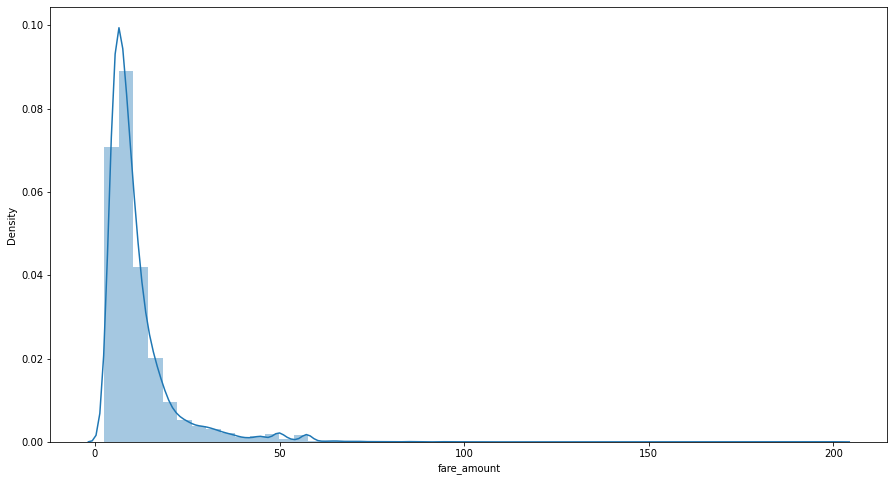

In [ ]:
##Distribution of Fare
plt.figure(figsize=(15, 8))
sns.distplot(eda['fare_amount'])

In [ ]:
##Plot locations with heatmap intensity as per the FARE
m = folium.Map()
sw = eda[['pickup_latitude', 'pickup_longitude']].min().values.tolist()
ne = eda[['pickup_latitude', 'pickup_longitude']].max().values.tolist()
m.add_child(plugins.HeatMap(zip(eda['pickup_latitude'], eda['pickup_longitude'], eda['fare_amount']), radius = 10))
m.fit_bounds([sw, ne])
m

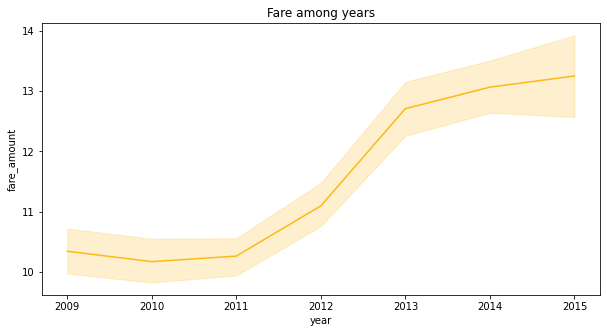

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x="year", y="fare_amount", data=data, color="#fdb813")
plt.title("Fare among years")
plt.show()

# Feature Generation

In [ ]:
def get_cleaned(df):
    return df[(df.fare_amount > 0) &
              (df.pickup_latitude > 35) & (df.pickup_latitude < 45) &
              (df.pickup_longitude > -80) & (df.pickup_longitude < -68) &
              (df.dropoff_latitude > 35) & (df.dropoff_latitude < 45) &
              (df.pickup_longitude > -80) & (df.dropoff_longitude < -68) &
              (df.passenger_count > 0) & (df.passenger_count < 8)]

data = get_cleaned(data)
print(len(data))
print("Data lost after the cleaning process: ", 7000000 - len(data))

1023412
Data lost after the cleaning process:  5976588


In [ ]:
def datetime_info(df):
    #Convert to datetime format
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    df['hour'] = df.pickup_datetime.dt.hour
    df['day'] = df.pickup_datetime.dt.day
    df['month'] = df.pickup_datetime.dt.month
    df['weekday'] = df.pickup_datetime.dt.weekday
    df['year'] = df.pickup_datetime.dt.year
    
    return df


In [ ]:
data = datetime_info(data)


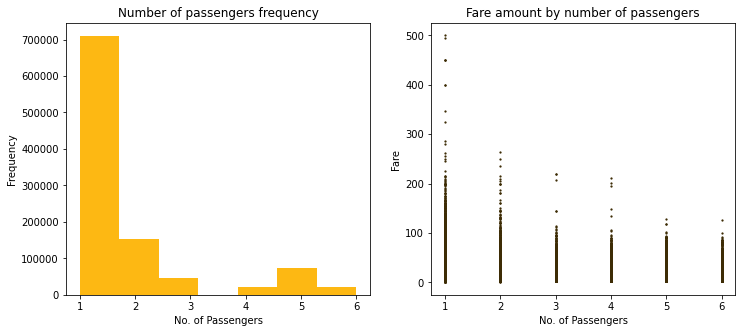

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].hist(data["passenger_count"], bins=7, color=("#fdb813"))
ax[0].set_title("Number of passengers frequency")
ax[0].set_xlabel('No. of Passengers')
ax[0].set_ylabel('Frequency')

ax[1].scatter(x=data["passenger_count"], y=data["fare_amount"], s=1.5, 
              color=("#3D2C05"))
ax[1].set_title("Fare amount by number of passengers")
ax[1].set_xlabel('No. of Passengers')
ax[1].set_ylabel('Fare');

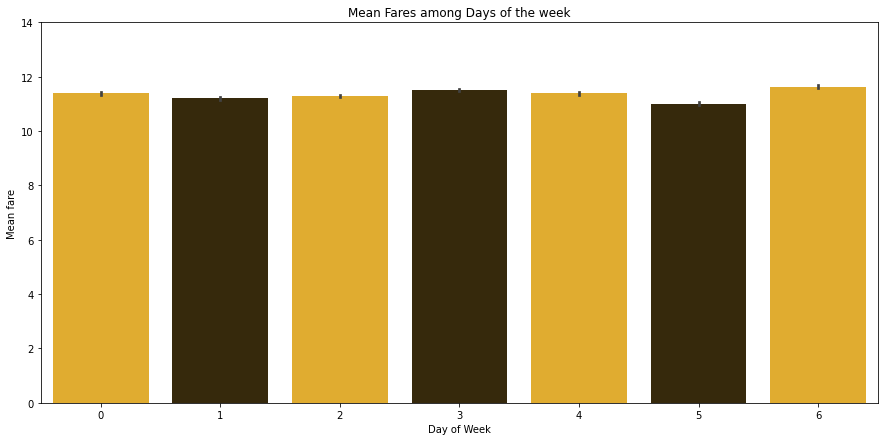

In [ ]:
plt.figure(figsize=(15,7))
sns.barplot(x='weekday', y="fare_amount", data=data, palette=("#fdb813", "#3D2C05"))
plt.ylim(0, 14)
plt.title("Mean Fares among Days of the week")
plt.xlabel('Day of Week')
plt.ylabel('Mean fare')
plt.show()

In [ ]:
##Calculate Euclidean distance
from scipy.spatial import distance
def euclidean(row):
  # print(row)
  a = (row['pickup_latitude'], row['pickup_longitude'])
  b = (row['dropoff_latitude'], row['dropoff_longitude'])
  row['distance'] = distance.euclidean(a, b) * 100
  return row

data = data.apply(euclidean, axis=1)
data.head()  

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,distance
0,26:21.0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,0,2009,0.943584
1,52:16.0,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,1,2010,7.969567
2,35:00.0,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,3,2011,1.367404
3,30:42.0,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,5,2012,2.534047
4,51:00.0,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,1,2010,1.946952


In [ ]:
##Drop useless columns
df = df.drop(['trip_start_timestamp','pickup_census_tract',
              'dropoff_census_tract','payment_type','tips', 
              'company','dropoff_community_area','pickup_community_area'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare               15002 non-null  float64
 1   trip_start_month   15002 non-null  int64  
 2   trip_start_hour    15002 non-null  int64  
 3   trip_start_day     15002 non-null  int64  
 4   pickup_latitude    15000 non-null  float64
 5   pickup_longitude   15000 non-null  float64
 6   dropoff_latitude   14519 non-null  float64
 7   dropoff_longitude  14519 non-null  float64
 8   trip_miles         15002 non-null  float64
 9   trip_seconds       14996 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 1.1 MB


### Data - **Exploration**

We sample a small amount of training data, which we use for EDA / VDA and feature engineering. The same knowledge will then be applied when we build the model called as **feature engineering**.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


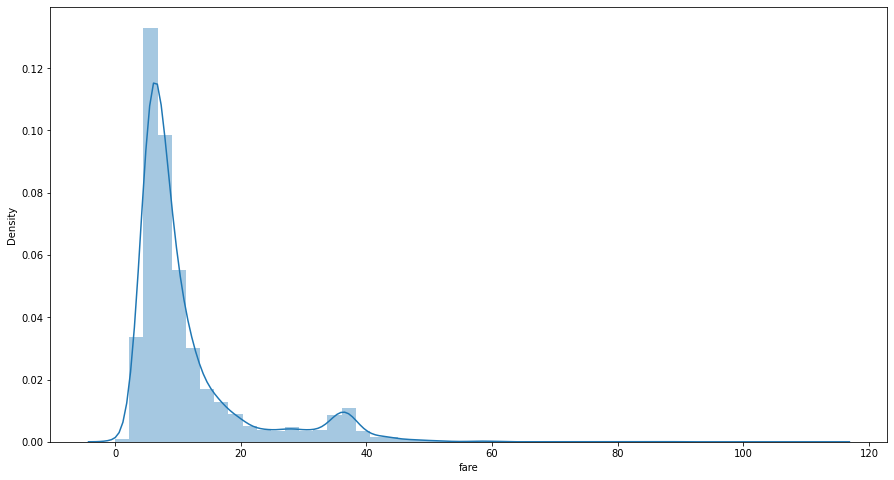

In [ ]:
##Distribution of Fare
plt.figure(figsize=(15, 8))
sns.distplot(traindf['fare'])

In [ ]:

bins_lat = pd.qcut(list(data['dropoff_latitude'].values) + list(data['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]


bins_lon = pd.qcut(list(data['dropoff_longitude'].values) + list(data['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]


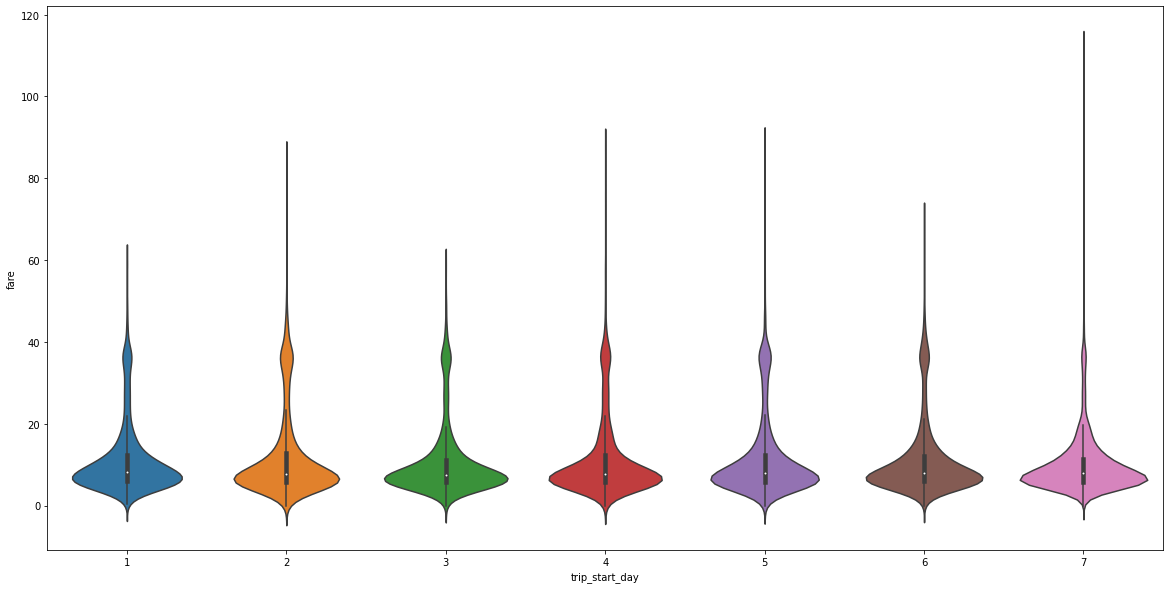

In [ ]:
plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_day'].astype(int), y=traindf['fare'])

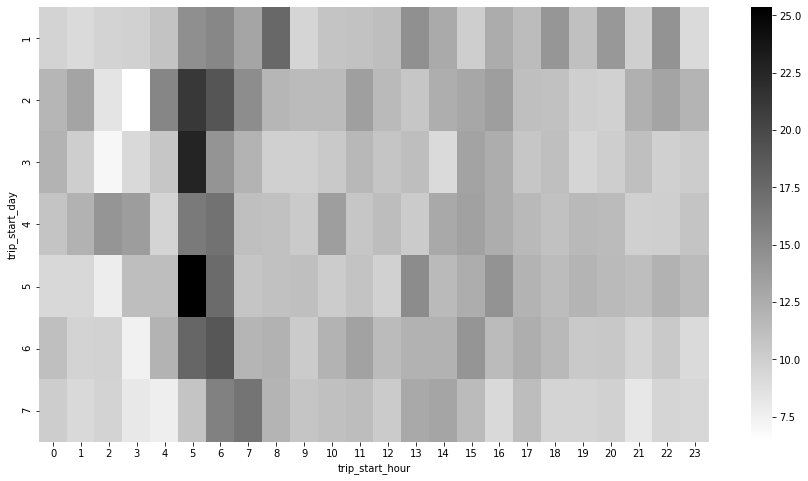

In [ ]:
##Average trip fare( day & hour combined )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['fare'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

**Feature engineering exploration**:



In [ ]:
##Calculate Euclidean distance
from scipy.spatial import distance
def euclidean(row):
  # print(row)
  a = (row['pickup_latitude'], row['pickup_longitude'])
  b = (row['dropoff_latitude'], row['dropoff_longitude'])
  row['distance'] = distance.euclidean(a, b) * 100
  return row

traindf = traindf.apply(euclidean, axis=1)
traindf.head()  

,fare,trip_start_month,trip_start_hour,trip_start_day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance
28,12.25,10,1,1,41.952823,-87.653244,41.920452,-87.679955,4.196872
29,3.85,3,15,6,41.899670,-87.669838,41.920452,-87.679955,2.311313
30,6.05,8,23,5,41.906026,-87.675312,41.920452,-87.679955,1.515438
31,7.25,10,21,7,41.906651,-87.665338,41.920452,-87.679955,2.010275
32,7.85,11,11,2,41.871016,-87.631407,41.849247,-87.624135,2.295137


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


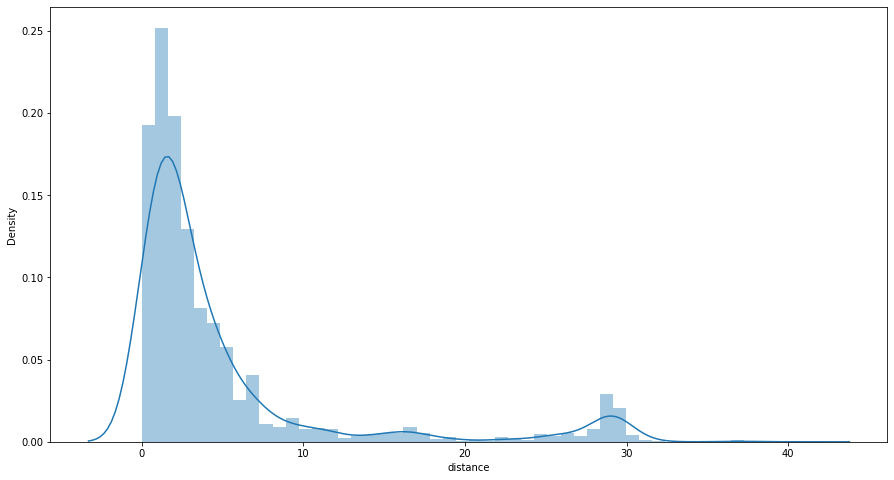

In [ ]:
plt.figure(figsize=(15, 8))
sns.distplot(traindf['distance'])

In [ ]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)
traindf.head()

12347
2171


,fare,trip_start_month,trip_start_hour,trip_start_day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
28,12.25,10,1,1,41.952823,-87.653244,41.920452,-87.679955
29,3.85,3,15,6,41.899670,-87.669838,41.920452,-87.679955
30,6.05,8,23,5,41.906026,-87.675312,41.920452,-87.679955
31,7.25,10,21,7,41.906651,-87.665338,41.920452,-87.679955
32,7.85,11,11,2,41.871016,-87.631407,41.849247,-87.624135


### Data - **Ingestion Pipeline**

Till now, we explored the sample data in Pandas for understanding patterns, doing cleansing, pre-processing, feature engineering. However the complete training data can be much larger in size( possibly TB or more ) which can't be processed at once using Pandas.

In this step using **TF.Data** API, we setup a **pipeline** which reads data in **batches** from infinite-sized files or other data sources, applies transformations( feature engineering etc. ) and the result data is then directly fed as input to an algorithm for model training.

There are some best practices to be incorporated when using TF Data API in order to maximize the IO throughput.
1. Prefetch() -> Fetch data for next iterations in current iteration itself
2. Interleave() -> Open connections to multiple files at once( sharding )
3. Map() -> Apply transformation to input data, create new features

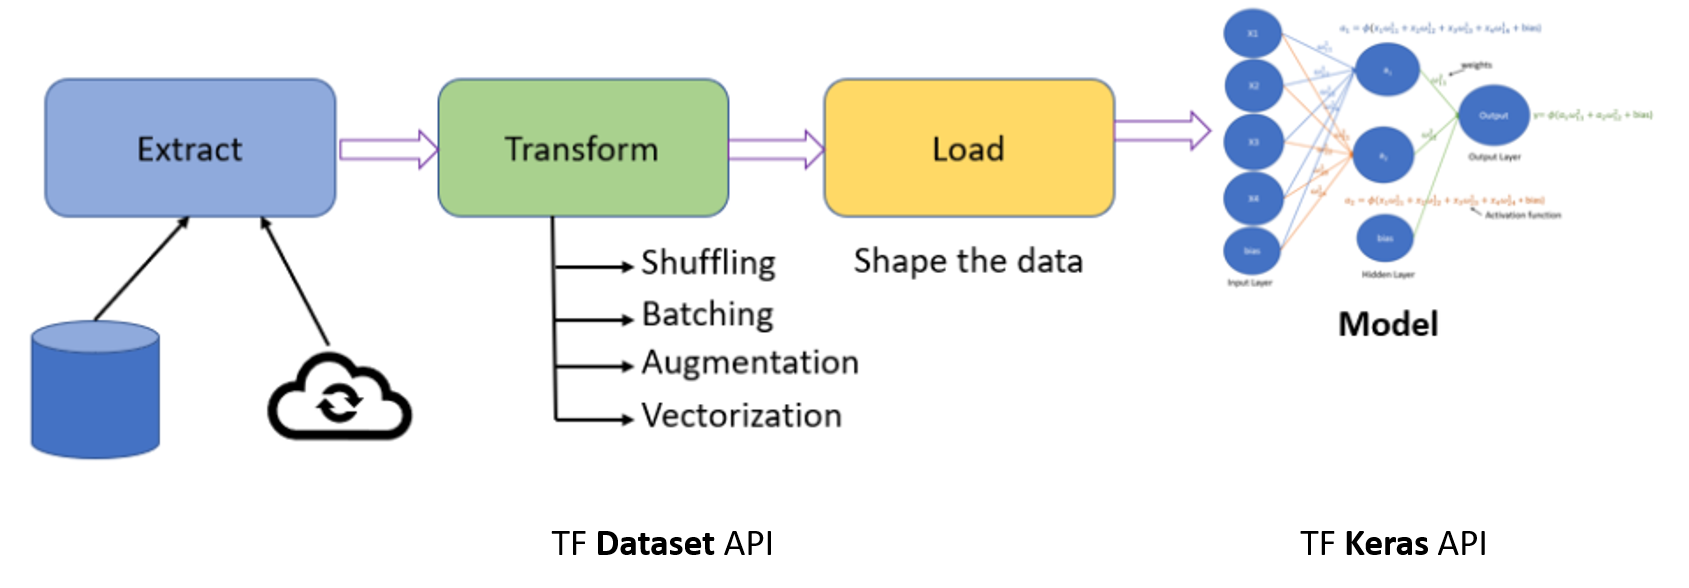

In [ ]:
##Feature engineering functions
def feature_engg_features(features):
  print(tf.strings.split(features['pickup_datetime']))
  #Add new features, parsing date into year, month, day, and hour. Calculating euclidien distance 
  features['distance'] = ((features['pickup_latitude'] - features['dropoff_latitude'])**2 +  (features['pickup_longitude'] - features['dropoff_longitude'])**2)**0.5
  features['year'] = tf.strings.substr(features['pickup_datetime'],0,4)
  features['month'] = tf.strings.substr(features['pickup_datetime'],5,2)
  features['day'] = tf.strings.substr(features['pickup_datetime'],8,2)
  features['hour'] = tf.strings.substr(features['pickup_datetime'],11,2)

  return(features)

#To be called from TF
def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)  

In [ ]:
###Data Input pipeline function

"""
 0   key                1048575 non-null  object 
 1   fare_amount        1048575 non-null  float64
 2   pickup_datetime    1048575 non-null  object 
 3   pickup_longitude   1048575 non-null  float64
 4   pickup_latitude    1048575 non-null  float64
 5   dropoff_longitude  1048565 non-null  float64
 6   dropoff_latitude   1048565 non-null  float64
 7   passenger_count    1048575 non-null  int64  
 """
CSV_COLUMNS = ['key','fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count']
LABEL_COLUMN = 'fare_amount'


def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        print(filename)
        file_list = tf.io.gfile.glob(filename)
        print(file_list)
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
        else:
            num_epochs = 1 # end-of-input after this        
        
        # Create dataset from file list
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(file_list,
                                                   batch_size=batch_size,
                                                   column_names=CSV_COLUMNS,
                                                   column_defaults=None,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   num_parallel_reads=30)
        
        dataset = dataset.prefetch(buffer_size = batch_size)

        #Feature engineering
        dataset = dataset.map(feature_engg)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
            dataset = dataset.shuffle(buffer_size = batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs)       
        
        return dataset
    return _input_fn

In [ ]:
#Reading the dataset and feature engineering
eval_file = "train*.csv"
fn_d = make_input_fn(f'/content/drive/MyDrive/CMPE-258/HW5/new-york-city-taxi-fare-prediction/train.csv',
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 10)

data = fn_d(v_test=True)

/content/drive/MyDrive/CMPE-258/HW5/new-york-city-taxi-fare-prediction/train.csv
['/content/drive/MyDrive/CMPE-258/HW5/new-york-city-taxi-fare-prediction/train.csv']
tf.RaggedTensor(values=Tensor("StringSplit/StringSplitV2:1", shape=(None,), dtype=string), row_splits=Tensor("StringSplit/RaggedFromValueRowIds/RowPartitionFromValueRowIds/concat:0", shape=(None,), dtype=int64))
OrderedDict([('key', <tf.Tensor 'args_2:0' shape=(None,) dtype=string>), ('pickup_datetime', <tf.Tensor 'args_4:0' shape=(None,) dtype=string>), ('pickup_longitude', <tf.Tensor 'args_6:0' shape=(None,) dtype=float32>), ('pickup_latitude', <tf.Tensor 'args_5:0' shape=(None,) dtype=float32>), ('dropoff_longitude', <tf.Tensor 'args_1:0' shape=(None,) dtype=float32>), ('dropoff_latitude', <tf.Tensor 'args_0:0' shape=(None,) dtype=float32>), ('passenger_count', <tf.Tensor 'args_3:0' shape=(None,) dtype=int32>), ('distance', <tf.Tensor 'pow_2:0' shape=(None,) dtype=float32>), ('year', <tf.Tensor 'Substr:0' shape=(None,) 

In [ ]:
# Define feature columns(Including feature engineered ones )
def create_feature_cols():
    #Keras format features
    """
      'pickup_datetime'   
      'pickup_longitude'  
      'pickup_latitude'   
      'dropoff_longitude' 
      'dropoff_latitude'  
      'passenger_count'   
      'distance'          
      'year'              
      'month'             
      'day'               
      'hour' 
    """
    k_month = tf.keras.Input(name='month', shape=(1,), dtype=tf.string)
    k_hour  = tf.keras.Input(name='hour', shape=(1,), dtype=tf.string)
    k_day  = tf.keras.Input(name='day', shape=(1,), dtype=tf.string)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32)
    k_passenger_count = tf.keras.Input(name='passenger_count', shape=(1,),dtype=tf.float32)
    keras_dict_input = {'month': k_month, 'hour': k_hour, 'day' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 'dropoff_longitude': k_droplon, 'distance' : k_distance,'passenger_count':k_passenger_count
                        }

    return({'K' : keras_dict_input})

create_feature_cols()

{'K': {'day': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'day')>,
  'distance': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>,
  'dropoff_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_latitude')>,
  'dropoff_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_longitude')>,
  'hour': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'hour')>,
  'month': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'month')>,
  'passenger_count': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'passenger_count')>,
  'pickup_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_latitude')>,
  'pickup_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_longitude')>}}

### **Model - Training pipeline**

We are going to build a Deep Neural Network which will comprise of following in-model feature engineering techniques:
1. One-Hot encode all categorical attributes
2. Feature cross: Cross-join categorical attributes( ex: Lat cross Lon )
3. Network architecture: Wide( Categorical  ) and Deep( Continuous features )
4. Regularization( Overfit prevention ): L2
5. Uses GPU / TPU as distribution infra

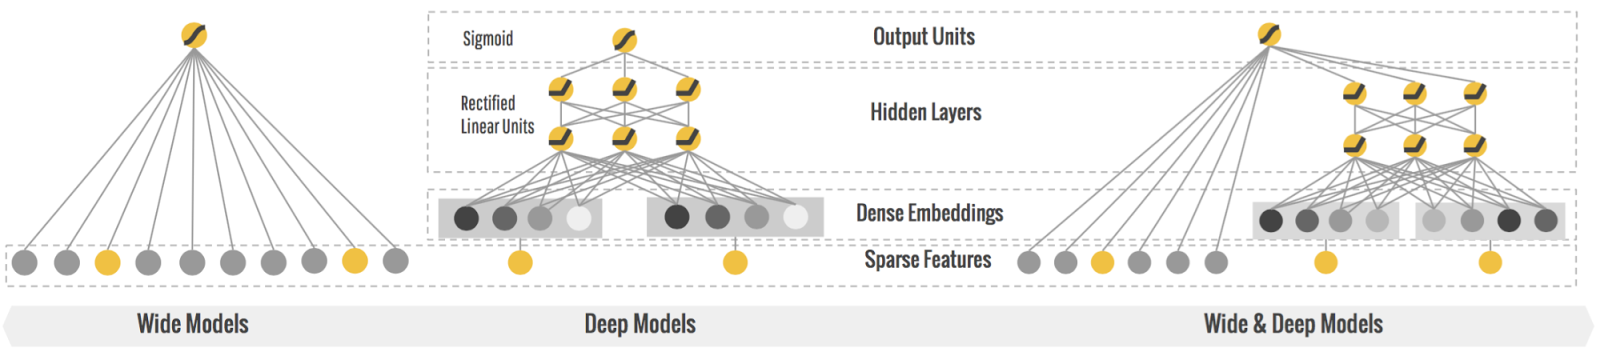

In [ ]:
#Create model
params_default = {
    'lr' : 0.001,
    'beta_1' : 0.99,
    'beta_2' : 0.999,
    'epsilon' : 1e-08,
    'decay' : 0.01,
    'hidden_layers' : 1
}

def create_keras_model(params, feature_cols):
    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])
    print(input_feats)
    ##Input processing
    ##https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
    ##https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md

    ##Handle categorical attributes( One-hot encoding )
    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23', '24',
                                                                                      '25', '26', '27', '28', '29', '30','31'], mask_token=None)(feature_cols['K']['day'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=31)(cat_day)

    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=12)(cat_month)

    # ##Binning 
    bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=24 * 31)(cross_day_hour)
    cat_cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = 24* 31)(hash_cross_day_hour)

    cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
    hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

    cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
    hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
    embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
    embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

    embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
    embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    # Also pass time attributes as Deep signal( Cast to integer )
    int_trip_start_day = tf.strings.to_number(feature_cols['K']['day'], tf.float32)
    int_trip_start_hour = tf.strings.to_number(feature_cols['K']['hour'], tf.float32)
    int_trip_start_month = tf.strings.to_number(feature_cols['K']['month'], tf.float32)

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['distance'], feature_cols['K']['passenger_count'], 
                    embed_cross_pick_lon_lat, embed_cross_drop_lon_lat,
                    int_trip_start_day, int_trip_start_hour, int_trip_start_month
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_input_categ = tf.keras.layers.concatenate([
                    cat_month, cat_cross_day_hour, cat_pickup_lat, cat_pickup_lon, cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    x_categ = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'], beta_1=params['beta_1'], 
                                        beta_2=params['beta_2'], epsilon=params['epsilon'])

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

In [ ]:
def keras_train_and_evaluate(model, train_dataset, validation_dataset, epochs=100):
  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.00001, verbose = 1)
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

  #Train and Evaluate
  out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=epochs,
                  steps_per_epoch = 100,   
                  callbacks=[reduce_lr, 
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True)]
                  )

/content/drive/MyDrive/CMPE-258/HW5/new-york-city-taxi-fare-prediction/train.csv
['/content/drive/MyDrive/CMPE-258/HW5/new-york-city-taxi-fare-prediction/train.csv']
tf.RaggedTensor(values=Tensor("StringSplit/StringSplitV2:1", shape=(None,), dtype=string), row_splits=Tensor("StringSplit/RaggedFromValueRowIds/RowPartitionFromValueRowIds/concat:0", shape=(None,), dtype=int64))
OrderedDict([('key', <tf.Tensor 'args_2:0' shape=(128,) dtype=string>), ('pickup_datetime', <tf.Tensor 'args_4:0' shape=(128,) dtype=string>), ('pickup_longitude', <tf.Tensor 'args_6:0' shape=(128,) dtype=float32>), ('pickup_latitude', <tf.Tensor 'args_5:0' shape=(128,) dtype=float32>), ('dropoff_longitude', <tf.Tensor 'args_1:0' shape=(128,) dtype=float32>), ('dropoff_latitude', <tf.Tensor 'args_0:0' shape=(128,) dtype=float32>), ('passenger_count', <tf.Tensor 'args_3:0' shape=(128,) dtype=int32>), ('distance', <tf.Tensor 'pow_2:0' shape=(128,) dtype=float32>), ('year', <tf.Tensor 'Substr:0' shape=(128,) dtype=str

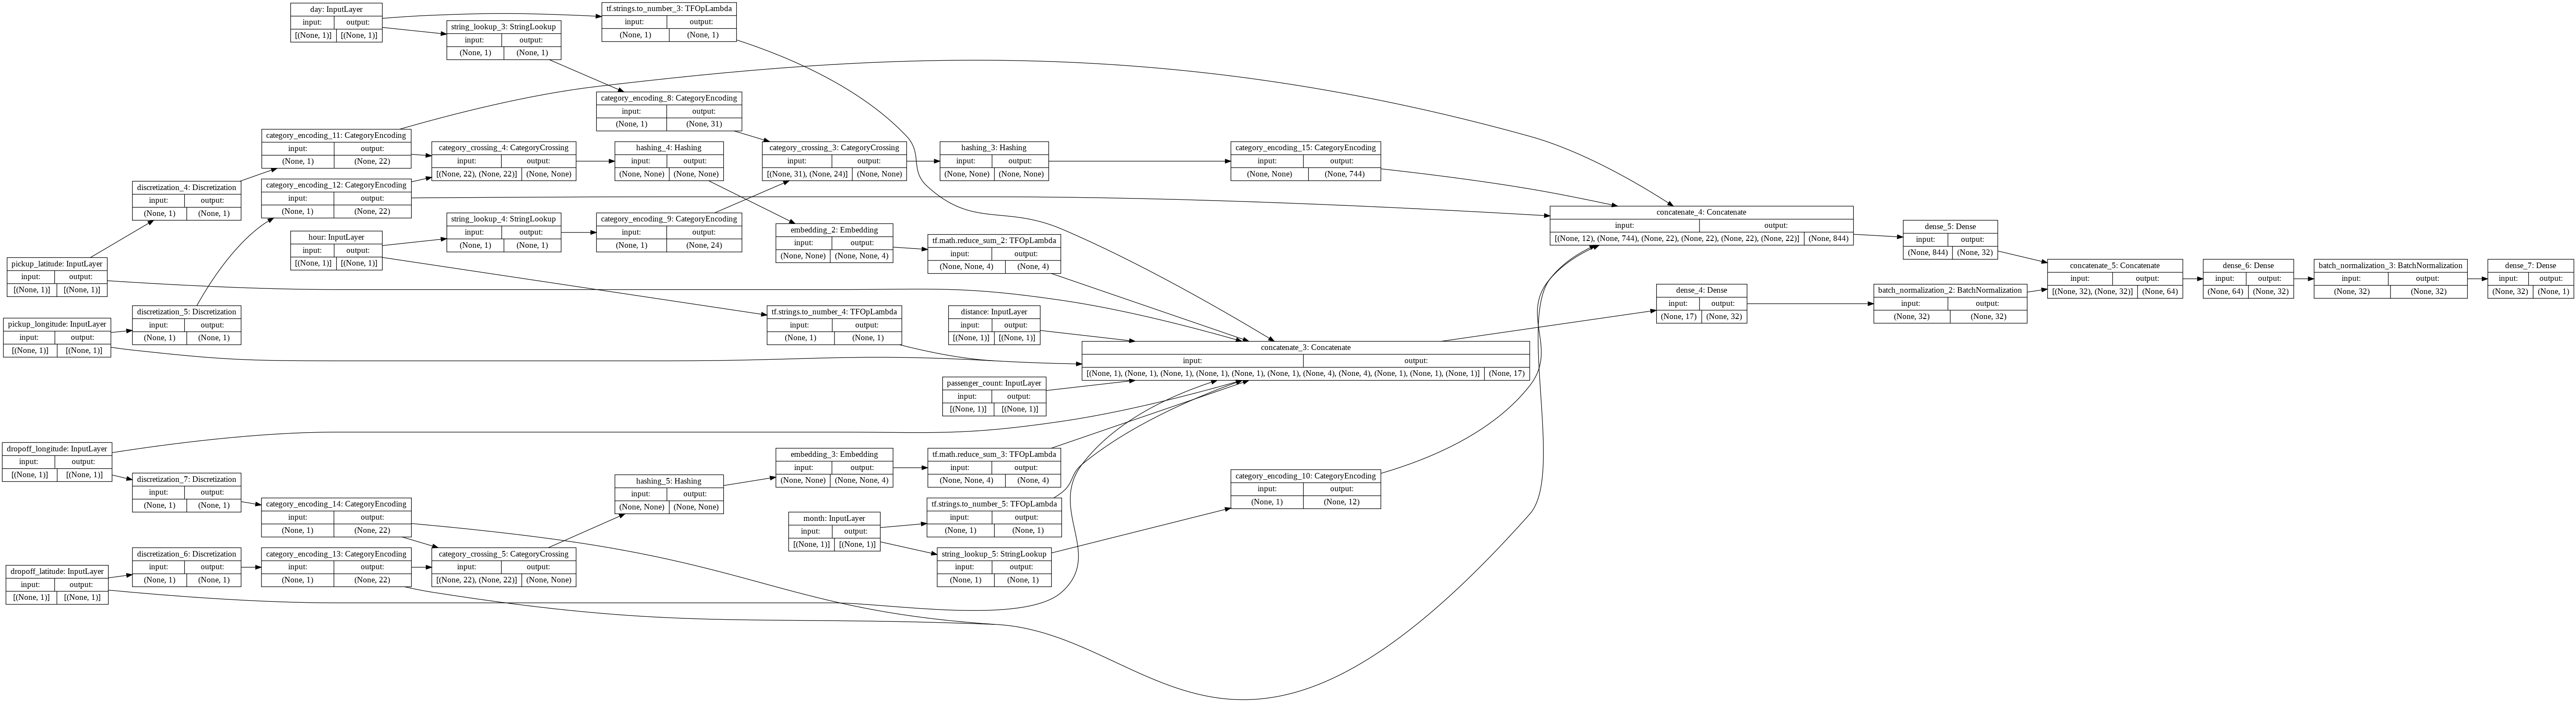

In [ ]:
#Create training and validation datasets
train_dataset = make_input_fn(filename = '/content/drive/MyDrive/CMPE-258/HW5/new-york-city-taxi-fare-prediction/train.csv',
                    mode = tf.estimator.ModeKeys.TRAIN,
                    # vnum_epochs = epochs,
                    batch_size = 128)()

validation_dataset = make_input_fn(filename = 'eval*.csv',
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 512)()

features = create_feature_cols()
m_ = create_keras_model(params = params_default, feature_cols = features)
tf.keras.utils.plot_model(m_, show_shapes=True, rankdir="LR")

In [ ]:
train_dataset

<DatasetV1Adapter shapes: (OrderedDict([(key, (128,)), (pickup_datetime, (128,)), (pickup_longitude, (128,)), (pickup_latitude, (128,)), (dropoff_longitude, (128,)), (dropoff_latitude, (128,)), (passenger_count, (128,)), (distance, (128,)), (year, (128,)), (month, (128,)), (day, (128,)), (hour, (128,))]), (128,)), types: (OrderedDict([(key, tf.string), (pickup_datetime, tf.string), (pickup_longitude, tf.float32), (pickup_latitude, tf.float32), (dropoff_longitude, tf.float32), (dropoff_latitude, tf.float32), (passenger_count, tf.int32), (distance, tf.float32), (year, tf.string), (month, tf.string), (day, tf.string), (hour, tf.string)]), tf.float32)>

In [ ]:

keras_train_and_evaluate(m_, train_dataset, validation_dataset, 50)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 180.9148 - rmse: 13.4504WARNING:tensorflow:Using a while_loop for converting BoostedTreesBucketize


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['key', 'pickup_datetime', 'year'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


100/100 [==============================] - 21s 210ms/step - loss: 180.9148 - rmse: 13.4504 - val_loss: 166.1662 - val_rmse: 12.8905
Epoch 2/50
100/100 [==============================] - 20s 201ms/step - loss: 131.4559 - rmse: 11.4654 - val_loss: 105.4429 - val_rmse: 10.2685
Epoch 3/50
100/100 [==============================] - 20s 199ms/step - loss: 101.6833 - rmse: 10.0838 - val_loss: 114.3905 - val_rmse: 10.6953
Epoch 4/50
100/100 [==============================] - 20s 200ms/step - loss: 80.0202 - rmse: 8.9454 - val_loss: 93.1759 - val_rmse: 9.6527
Epoch 5/50
100/100 [==============================] - 20s 197ms/step - loss: 70.6668 - rmse: 8.4063 - val_loss: 111.1070 - val_rmse: 10.5407
Epoch 6/50
100/100 [==============================] - 20s 199ms/step - loss: 62.0593 - rmse: 7.8777 - val_loss: 116.0675 - val_rmse: 10.7734
Epoch 7/50
100/100 [==============================] - 20s 199ms/step - loss: 58.5938 - rmse: 7.6546 - val_loss: 80.3073 - val_rmse: 8.9614
Epoch 8/50
100/100 [==

### **Serving: Export model**

In [ ]:
# ## Prediction directly using model's instance
data = tf.data.Dataset.from_tensor_slices({'dropoff_latitude': [[41.920452]],
                         'dropoff_longitude': [[-87.679955]],
                         'pickup_latitude': [[41.952823]],
                         'pickup_longitude': [[-87.653244]],
                         'day': [["1"]],
                         'hour': [["5"]],
                         'month': [["6"]],
                         'distance':[[0.04196861]],
                         'passenger_count':[[2.0]]
                         })

m_.predict(data)

array([[22.436863]], dtype=float32)

In [ ]:
@tf.function
def serving(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude,date,passenger_count):
    ##Feature engineering( calculate distance )
    distance = tf.cast( tf.sqrt((tf.abs(dropoff_latitude - pickup_latitude))**2 + (tf.abs(dropoff_longitude - pickup_longitude))**2), tf.float32)
    trip_start_month = tf.strings.substr(date,5,2)
    trip_start_day = tf.strings.substr(date,8,2)
    trip_start_hour = tf.strings.substr(date,11,2)
    payload = {
        'dropoff_latitude': dropoff_latitude,
        'dropoff_longitude': dropoff_longitude,
        'pickup_latitude': pickup_latitude,
        'pickup_longitude': pickup_longitude,
        'day': trip_start_day,
        'hour': trip_start_hour,
        'month': trip_start_month,
        'distance': distance,
        'passenger_count': passenger_count
    }
    
    ## Predict
    predictions = m_(payload)
    return predictions

serving = serving.get_concrete_function(date=tf.TensorSpec([None,], dtype=tf.string, name='pickup_datetime'),
                                        passenger_count=tf.TensorSpec([None,],dtype=tf.float32, name='passenger_count') ,
                                        dropoff_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_latitude'),
                                        dropoff_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_longitude'), 
                                        pickup_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_latitude'),
                                        pickup_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_longitude')
                                        )

version = "1"  #{'serving_default': call_output}
tf.saved_model.save(
    m_,
    "./exported_model/" + version,
    signatures=serving
) 



INFO:tensorflow:Assets written to: ./exported_model/1/assets


In [ ]:
!tar -cvf /content/model.tar /content/exported_model/1/

tar: Removing leading `/' from member names
/content/exported_model/1/
/content/exported_model/1/assets/
/content/exported_model/1/variables/
/content/exported_model/1/variables/variables.data-00000-of-00001
/content/exported_model/1/variables/variables.index
/content/exported_model/1/saved_model.pb


In [ ]:
##Check signature
!saved_model_cli show --dir "./exported_model/1" --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dropoff_latitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_latitude:0
    inputs['dropoff_longitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_longitude:0
    inputs['passenger_count'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_passenger_count:0
    inputs['pickup_datetime'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
 

In [ ]:
#Local Prediction
saved_mod = tf.saved_model.load("./exported_model/" + version)

f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([41.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), pickup_datetime=tf.convert_to_tensor(["2009-06-15 17:26:21"]), passenger_count=tf.convert_to_tensor([5.0]))

{'output_0': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[23.495445]], dtype=float32)>}

In [ ]:
###Install TF Model server

!apt-get remove tensorflow-model-server
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  tensorflow-model-server
0 upgraded, 0 newly installed, 1 to remove and 50 not upgraded.
After this operation, 0 B of additional disk space will be used.
(Reading database ... 160984 files and directories currently installed.)
Removing tensorflow-model-server (2.5.0) ...
deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   159k      0 --:--:-- --:--:-- --:--:--  159k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86

In [ ]:
# Starting tensorflow model server
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8505 \
  --model_name=model \
  --model_base_path="/content/exported_model" >server.log 2>&1

Starting job # 2 in a separate thread.


In [ ]:
!tail server.log

2021-04-17 09:36:48.651319: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /content/exported_model/1
2021-04-17 09:36:48.705695: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 250977 microseconds.
2021-04-17 09:36:48.716560: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /content/exported_model/1/assets.extra/tf_serving_warmup_requests
2021-04-17 09:36:48.716703: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: model version: 1}
2021-04-17 09:36:48.718691: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-04-17 09:36:48.718754: I tensorflow_serving/model_servers/server.cc:367] Profiler service is enabled
2021-04-17 09:36:48.719273: I tensorflow_serving/model_servers/server.cc:393] Running gRPC

In [ ]:
# Making request to deployed model
import json
import requests

#Create payload
data_py = {"instances":[{
        'dropoff_latitude': 41.920452,
        'dropoff_longitude': -87.679955,
        'pickup_latitude': 41.952823,
        'pickup_longitude': -87.653244,
        'pickup_datetime':'2009-01-15 17:26:21',
        'passenger_count':1}]
    }
                    

data = json.dumps(data_py)
print("payload: ", data)

#Run request on TMS
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8505/v1/models/model:predict', data=data, headers=headers)
json_response.text

payload:  {"instances": [{"dropoff_latitude": 41.920452, "dropoff_longitude": -87.679955, "pickup_latitude": 41.952823, "pickup_longitude": -87.653244, "pickup_datetime": "2009-01-15 17:26:21", "passenger_count": 1}]}


'{\n    "predictions": [[23.3482609]\n    ]\n}'